In [1]:
import cv2
import numpy
import tensorflow
import keras
import os
import time
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
IMAGES_PATH = "../../dataset/Image/Face_detector/raw"
LABELS_PATH = "../../dataset/Image/Face_detector/Label"
DATASET_PATH = "../../dataset/Image/Face_detector"
numbers_capture_image = 80
if not os.path.exists(IMAGES_PATH):
    os.makedirs(IMAGES_PATH)

## Thu thập và lưu trữ dữ liệu thô

In [4]:
cap = cv2.VideoCapture(0)
for i in range(numbers_capture_image):
    print("Take a image"+str(i))
    ret, frame = cap.read()
    imagename = os.path.join(IMAGES_PATH, f"{i}.jpg")
    print(cv2.imwrite(imagename, frame))
    cv2.imshow("frame", frame)
    time.sleep(1)

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break
cap.release()
cv2.destroyAllWindows()

Take a image0


error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgcodecs\src\loadsave.cpp:783: error: (-215:Assertion failed) !_img.empty() in function 'cv::imwrite'


## Gán nhãn dữ liệu

In [ ]:
!labelme

In [23]:
jsonData = json.load(open("../../dataset/Image/Face_detector/Label/0.json"))
print(jsonData["shapes"][0]["label"])
print(jsonData["shapes"][0]["points"])

Face
[[294.1025641025641, 111.28205128205128], [560.7692307692307, 475.8974358974359]]


## Lấy dữ liệu thô

In [92]:
images_path = tensorflow.data.Dataset.list_files("../../dataset/Image/Face_detector/raw/*.jpg", shuffle=False)
RawDataset = images_path.as_numpy_iterator()

##### Hàm lấy dữ liệu

In [12]:
def LoadImage(x):
    byte_image = tensorflow.io.read_file(x)
    img = tensorflow.io.decode_jpeg(byte_image)
    return img

##### Lấy dữ liệu

In [93]:
images = images_path.map(LoadImage)

In [74]:
images_generator = images.batch(4).as_numpy_iterator()

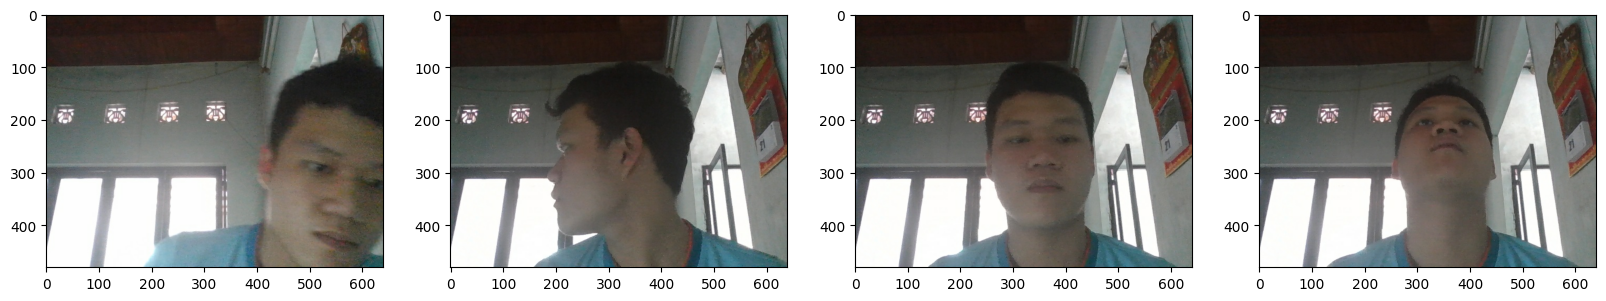

In [79]:
fig, ax = plt.subplots(1,4, figsize=(20,20))
for idx, image in enumerate(images_generator.next()):
    ax[idx].imshow(image)
plt.show()

## Chia dữ liệu

In [107]:
image_names = os.listdir(IMAGES_PATH)
label_names = os.listdir(LABELS_PATH)

In [120]:
X_train, X_remain= train_test_split(image_names,train_size=0.6)
X_val, X_test = train_test_split(X_remain,train_size=0.5)
print(f"Kích thước train, val, test: {len(X_train)}, {len(X_val)}, {len(X_test)}\
      \ntỉ lệ: {len(X_train)/len(image_names)} : {len(X_val)/len(image_names)} : {len(X_test)/len(image_names)}")

Kích thước train, val, test: 48, 16, 16      
tỉ lệ: 0.6 : 0.2 : 0.2


In [124]:
dataset = (X_train, X_val, X_test)

##### Lưu vào các thư mục train, val, test

In [125]:
for i, folder in enumerate(["train", "val", "test"]):
    if not os.path.exists(os.path.join(DATASET_PATH, folder, "images")):
        os.makedirs(os.path.join(DATASET_PATH, folder, "images"))
    if not os.path.exists(os.path.join(DATASET_PATH, folder, "labels")):
        os.makedirs(os.path.join(DATASET_PATH, folder, "labels"))
    for name in dataset[i]:
        name : str
        existing_image = os.path.join(IMAGES_PATH, name)
        existing_json = os.path.join(LABELS_PATH, name.split(".")[0] + ".json")
        if os.path.exists(existing_image):
            newpath = os.path.join(DATASET_PATH, folder, "images",name)
            os.replace(existing_image, newpath)
        if os.path.exists(existing_json):
            newpath = os.path.join(DATASET_PATH, folder, "labels",name.split(".")[0] + ".json")
            os.replace(existing_json, newpath)

## Làm giàu dữ liệu

In [3]:
import albumentations as alb
import uuid

In [4]:
augmentor = alb.Compose([alb.HorizontalFlip(p=0.5), alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), alb.RGBShift(p=0.5), alb.VerticalFlip(p=0.5)],
                         bbox_params=alb.BboxParams(format='albumentations', label_fields=["class_labels"]))

In [5]:
label = os.path.join(DATASET_PATH, "train", "labels", "0.json")
image = os.path.join(DATASET_PATH, "train", "images", "0.jpg")
image = cv2.imread(image)
label = json.load(open(label))

In [7]:
coord = label["shapes"][0]["points"]
cv2.rectangle(image, numpy.array(coord[0]).astype(int), numpy.array(coord[1]).astype(int), (255,0,0), 1)

array([[[ 30,  15,  43],
        [ 34,  19,  46],
        [ 36,  22,  46],
        ...,
        [145, 144, 118],
        [146, 142, 118],
        [145, 141, 117]],

       [[ 31,  18,  44],
        [ 32,  19,  45],
        [ 31,  19,  41],
        ...,
        [145, 144, 118],
        [145, 144, 118],
        [146, 145, 119]],

       [[ 25,  17,  40],
        [ 21,  14,  35],
        [ 16,   9,  30],
        ...,
        [140, 142, 113],
        [140, 142, 113],
        [142, 144, 115]],

       ...,

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [121, 118,  74],
        [123, 117,  80],
        [125, 120,  87]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [118, 118,  70],
        [127, 125,  85],
        [118, 116,  81]],

       [[254, 254, 254],
        [254, 254, 254],
        [254, 254, 254],
        ...,
        [109, 110,  60],
        [134, 135,  93],
        [125, 124,  86]]

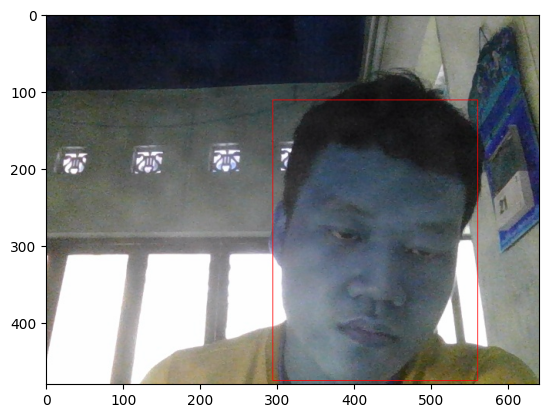

In [8]:
plt.imshow(image)

In [88]:
coord

[[294.1025641025641, 111.28205128205128],
 [560.7692307692307, 475.8974358974359]]

In [89]:
coords = [0,0,0,0]
coords[0] =coord[0][0]
coords[1] =coord[0][1]
coords[2] =coord[1][0]
coords[3] =coord[1][1]
coords = list(numpy.divide(coords, [640, 480, 640, 480]))

In [90]:

augmented = augmentor(image=image, bboxes=[coords], class_labels=["face"])

In [91]:
print(augmented.keys())

dict_keys(['image', 'bboxes', 'class_labels'])


In [103]:
aug_image = numpy.array(augmented['image'])
aug_bbox = numpy.array(augmented['bboxes'][0])
aug_class = augmented["class_labels"]

In [104]:
numpy.array(aug_bbox[0:2] * [640, 480]).astype(int)

array([294,   4])

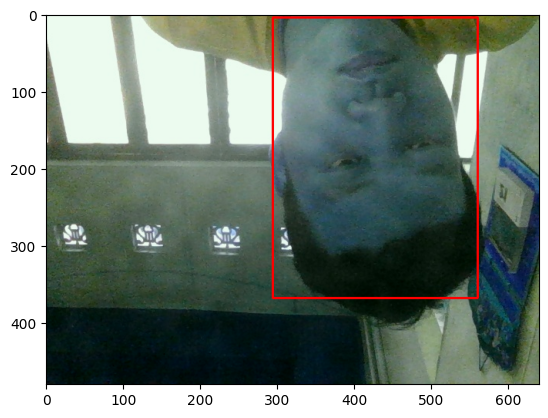

In [105]:
cv2.rectangle(aug_image, numpy.array(aug_bbox[0:2] * [640, 480]).astype(int), 
              numpy.array(aug_bbox[2:4] * [640, 480]).astype(int), (255,0,0), 2)
plt.imshow(aug_image)

In [10]:
for folder in ["train", "val", "test"]:
    if not os.path.exists(os.path.join(DATASET_PATH, "aug_data", folder, "images")):
        os.makedirs(os.path.join(DATASET_PATH, "aug_data", folder, "images"))
    if not os.path.exists(os.path.join(DATASET_PATH, "aug_data", folder, "labels")):
        os.makedirs(os.path.join(DATASET_PATH, "aug_data", folder, "labels"))
    for file in os.listdir(os.path.join(DATASET_PATH, folder, "images")):
        name = file.split(".")[0]
        label_path = os.path.join(DATASET_PATH, folder, "labels", f"{name}.json")
        image_path = os.path.join(DATASET_PATH, folder, "images", f"{name}.jpg")

        if os.path.exists(image_path):
            image = cv2.imread(image_path)
        coords = [0,0,0.00001,0.00001]
        if os.path.exists(label_path):
            label = json.load(open(label_path))
            coord = label["shapes"][0]["points"]
            coords[0] =coord[0][0]
            coords[1] =coord[0][1]
            coords[2] =coord[1][0]
            coords[3] =coord[1][1]
            if coords[0] > coords[2]:
                coords[2] =coord[0][0]
                coords[0] =coord[1][0]
            if coords[1] > coords[3]:
                coords[3] =coord[0][1]
                coords[1] =coord[1][1]
            coords = list(numpy.divide(coords, [640, 480, 640, 480]))
     
        for x in range(60):
            augmented = augmentor(image=image, bboxes=[coords], class_labels=["face"])
            cv2.imwrite(os.path.join(DATASET_PATH, "aug_data", folder, "images", f"{name}.{x}.jpg"), augmented["image"])

            labelData = {}
            labelData["image"] = file
            
            if os.path.exists(label_path):
                if len(augmented["bboxes"]) == 0:
                    labelData['bbox'] = [0,0,0,0]
                    labelData['class'] = 0
                else:
                    labelData['bbox'] = augmented['bboxes'][0]
                    labelData['class'] = 1
            else:
                labelData['bbox'] = [0,0,0,0]
                labelData['class'] = 0
            
            with open(os.path.join(DATASET_PATH, "aug_data", folder, "labels", f"{name}.{x}.json"), 'w') as f:
                json.dump(labelData, f)


##### Lấy dữ liệu đã làm giàu

In [13]:
train_images = tensorflow.data.Dataset.list_files("../../dataset/Image/Face_detector/aug_data/train/images/*.jpg",shuffle=False)
train_images = train_images.map(LoadImage)
train_images = train_images.map(lambda x: tensorflow.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [14]:
val_images = tensorflow.data.Dataset.list_files("../../dataset/Image/Face_detector/aug_data/val/images/*.jpg",shuffle=False)
val_images = val_images.map(LoadImage)
val_images = val_images.map(lambda x: tensorflow.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [15]:
test_images = tensorflow.data.Dataset.list_files("../../dataset/Image/Face_detector/aug_data/test/images/*.jpg",shuffle=False)
test_images = test_images.map(LoadImage)
test_images = test_images.map(lambda x: tensorflow.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

##### Lấy nhãn

In [16]:
def load_label(path):
    with open(path.numpy(), 'r', encoding="utf-8") as f:
        label = json.load(f)
    return [label['class'], label['bbox']]


In [17]:
train_labels = tensorflow.data.Dataset.list_files("../../dataset/Image/Face_detector/aug_data/train/labels/*.json",shuffle=False)

train_labels = train_labels.map(lambda x: tensorflow.py_function(load_label, [x], [tensorflow.uint8, tensorflow.float16]))
val_labels = tensorflow.data.Dataset.list_files("../../dataset/Image/Face_detector/aug_data/val/labels/*.json",shuffle=False)
val_labels = val_labels.map(lambda x: tensorflow.py_function(load_label, [x], [tensorflow.uint8, tensorflow.float16]))
test_labels = tensorflow.data.Dataset.list_files("../../dataset/Image/Face_detector/aug_data/test/labels/*.json",shuffle=False)
test_labels = test_labels.map(lambda x: tensorflow.py_function(load_label, [x], [tensorflow.uint8, tensorflow.float16]))

In [10]:
train_labels.as_numpy_iterator().next()

(1, array([0.1238, 0.2318, 0.5405, 0.991 ], dtype=float16))

In [18]:
len(train_images), len(val_images), len(test_images), len(train_labels), len(val_labels), len(test_labels)

(2880, 960, 960, 2880, 960, 960)

##### Tạo dataset

In [19]:
train = tensorflow.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)
val = tensorflow.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(5000)
val = val.batch(8)
val = val.prefetch(4)
test = tensorflow.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(5000)
test = test.batch(8)
test = test.prefetch(4)

In [20]:
train.as_numpy_iterator().next()[0].shape

(8, 120, 120, 3)

In [14]:
train.as_numpy_iterator().next()[1]

(array([1, 1, 1, 1, 1, 1, 1, 1], dtype=uint8),
 array([[0.5566  , 0.2158  , 0.9116  , 0.815   ],
        [0.6406  , 0.3547  , 0.9985  , 0.995   ],
        [0.2368  , 0.0887  , 0.5557  , 0.685   ],
        [0.2527  , 0.0438  , 0.5835  , 0.673   ],
        [0.0653  , 0.502   , 0.2808  , 0.8203  ],
        [0.5566  , 0.1848  , 0.9116  , 0.784   ],
        [0.002003, 0.659   , 0.3777  , 0.9966  ],
        [0.3376  , 0.3162  , 0.731   , 0.8013  ]], dtype=float16))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


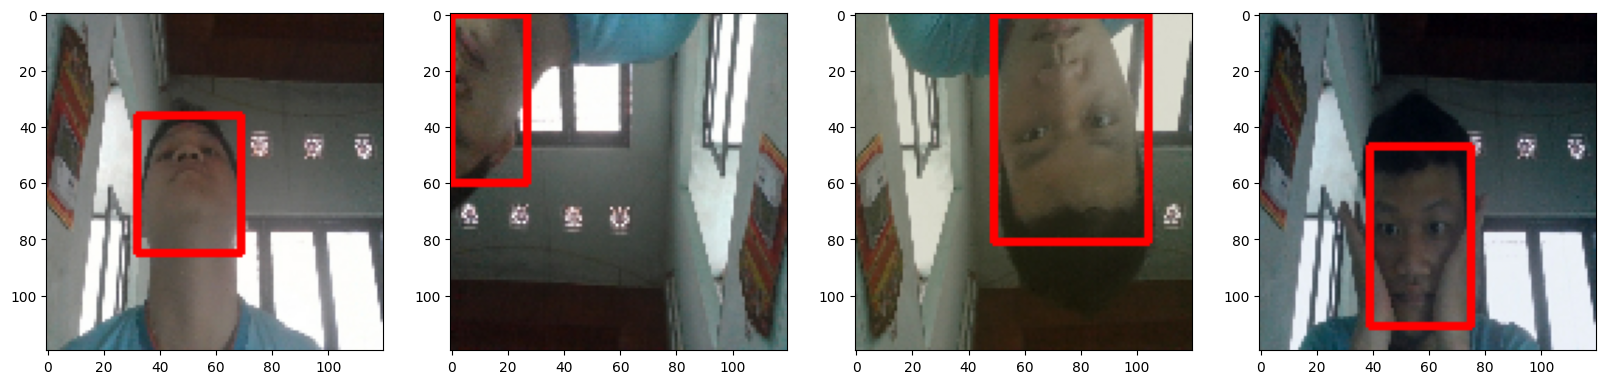

In [15]:
res = train.as_numpy_iterator().next()
fig, ax = plt.subplots(1,4, figsize=(20,20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coord = res[1][1][idx]
    cv2.rectangle(sample_image, numpy.multiply(sample_coord[:2], (120,120)).astype(int), 
                  numpy.multiply(sample_coord[2:], (120,120)).astype(int), (255,0,0), 2)
    ax[idx].imshow(sample_image)
plt.show()

##### Mô hình

In [21]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, GlobalMaxPooling2D
from keras.applications import VGG16
from keras.optimizers import Adam
from keras.callbacks import TensorBoard
from keras.losses import BinaryCrossentropy

In [22]:
vgg = VGG16(include_top=False)

In [23]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [24]:
def build_model():
    input_layer = Input(shape=(120,120,3))
    vgg = VGG16(include_top=False)(input_layer)
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation="relu")(f1)
    class2 = Dense(1, activation="sigmoid")(class1)
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation="relu")(f2)
    regress2 = Dense(4, activation="sigmoid")(regress1)

    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [25]:
facetracker = build_model()

In [26]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

##### Loss và optimizer

In [27]:
len(train)

360

In [28]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 - 1) / batches_per_epoch
opt = Adam(learning_rate=0.0001, decay=lr_decay)

In [29]:
def localizations_loss(y_true, y_predict):
    delta_coord = tensorflow.reduce_sum(tensorflow.square(y_true[:,:2] - y_predict[:,:2]))
    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_predict = y_predict[:,3] - y_predict[:,1]
    w_predict = y_predict[:,2] - y_predict[:,0]

    delta_size = tensorflow.reduce_sum(tensorflow.square(w_true - w_predict) + tensorflow.square(h_true - h_predict))

    return delta_coord + delta_size

In [30]:
classLoss = BinaryCrossentropy()
regressLoss = localizations_loss

## Huấn luyện mô hình

In [31]:
class FaceTracker(Model):
    def __init__(self, eyetracker, **kwargs):
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs):
        X, y = batch
        with tensorflow.GradientTape() as tape:
            classes, coords = self.model(X, training=True)
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tensorflow.cast(y[1], tensorflow.float32), coords)

            total_loss = batch_classloss + 0.5*batch_localizationloss
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        return {"total_loss" : total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tensorflow.cast(y[1], tensorflow.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [32]:
model = FaceTracker(facetracker)
model.compile(opt, classLoss, regressLoss)

In [33]:
logdir='logs'
tensorboard_callback = TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=5, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/5
360/360 [==============================] - 370s 1s/step - total_loss: 0.3625 - class_loss: 0.1429 - regress_loss: 0.4393 - val_total_loss: 0.1045 - val_class_loss: 0.0039 - val_regress_loss: 0.1026
Epoch 2/5
360/360 [==============================] - 373s 1s/step - total_loss: 0.0380 - class_loss: 0.0094 - regress_loss: 0.0572 - val_total_loss: 2.4413 - val_class_loss: 2.2562 - val_regress_loss: 1.3133
Epoch 3/5
360/360 [==============================] - 370s 1s/step - total_loss: 0.0267 - class_loss: 0.0079 - regress_loss: 0.0374 - val_total_loss: 3.0127 - val_class_loss: 2.3896 - val_regress_loss: 1.8179
Epoch 4/5
360/360 [==============================] - 371s 1s/step - total_loss: 0.0036 - class_loss: 1.6110e-04 - regress_loss: 0.0069 - val_total_loss: 1.7720 - val_class_loss: 1.8268 - val_regress_loss: 0.8586
Epoch 5/5
360/360 [==============================] - 375s 1s/step - total_loss: 0.0013 - class_loss: 3.9317e-05 - regress_loss: 0.0025 - val_total_loss: 3.6746 - va

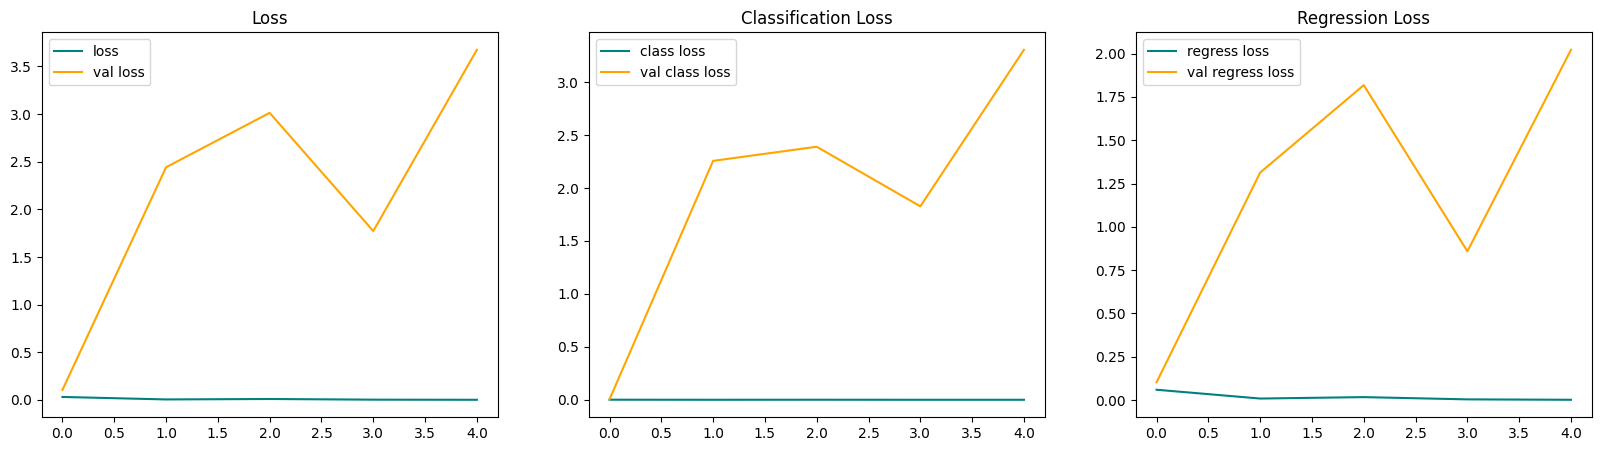

In [34]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

In [61]:
test_data = test.as_numpy_iterator().next()

1/1 [==============================] - 0s 176ms/step


1/1 [==============================] - 0s 348ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


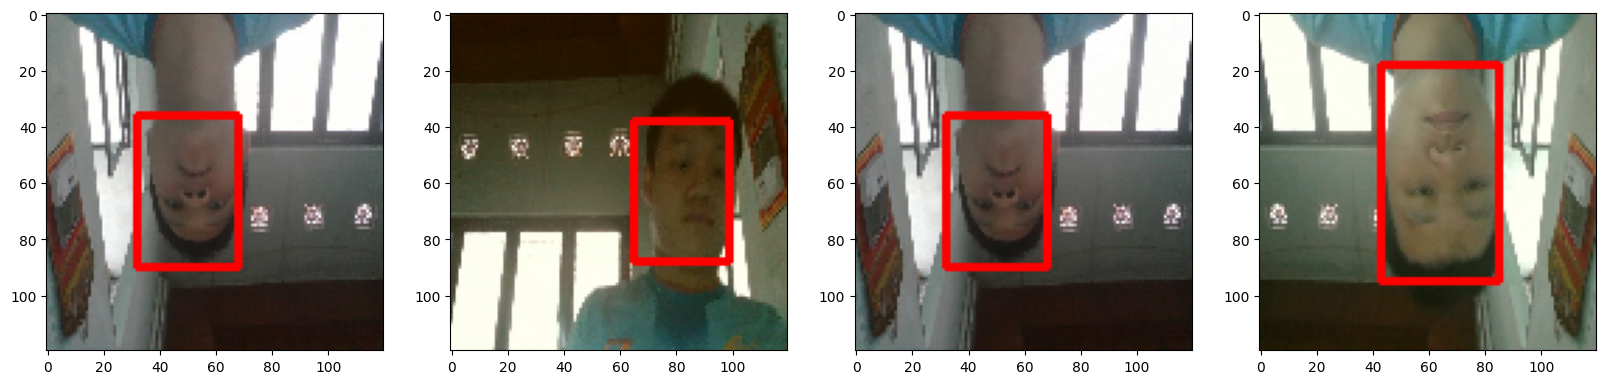

In [35]:
test_data = test.as_numpy_iterator().next()
yhat = model.predict(test_data[0])
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_data[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(numpy.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(numpy.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

##### Lưu mô hình

In [36]:
from keras.models import save_model

In [37]:
model.save("facetracking", save_format="tf")

INFO:tensorflow:Assets written to: facetracking\assets


INFO:tensorflow:Assets written to: facetracking\assets


In [38]:
loaded_model = keras.models.load_model("facetracking")

## Tạo API

In [39]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _, camera_frame = cap.read()
    rgb = cv2.cvtColor(camera_frame, cv2.COLOR_BGR2RGB)
    frame = tensorflow.image.resize(rgb, (120,120)) 
    predict = loaded_model.predict(numpy.expand_dims(frame/255,0))
    predict_coord = predict[1][0]

    if predict[0][0] > 0.5:
        cv2.rectangle(camera_frame, tuple(numpy.multiply(predict_coord[:2], [640,480]).astype(int)),
                        tuple(numpy.multiply(predict_coord[2:], [640,480]).astype(int)), (255,0,0), 2)
        cv2.rectangle(camera_frame, 
                      tuple(numpy.add(numpy.multiply(predict_coord[:2], [640,480]).astype(int), 
                                    [0,-30])),
                      tuple(numpy.add(numpy.multiply(predict_coord[:2], [640,480]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        cv2.putText(camera_frame, f'face {predict[0][0]}', tuple(numpy.add(numpy.multiply(predict_coord[:2], [640,480]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    cv2.imshow("frame", camera_frame)

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 49ms/step
